In [179]:
import sys
#!{sys.executable} -m pip install wordcloud
#!{sys.executable} -m pip install xgboost
#!{sys.executable} -m pip install nltk
#!{sys.executable} -m pip install textblob




In [204]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
#nltk.download('all')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from nltk.corpus import stopwords
from textblob import TextBlob
import plotly.figure_factory as ff
url = 'https://raw.githubusercontent.com/breanna-s/Mental-Health-Chatbot/refs/heads/main/Combined%20Data.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [181]:
df.isnull().sum()


Unnamed: 0      0
statement     362
status          0
dtype: int64

In [182]:
df.dropna(how='any', axis=0, inplace=True)
df.isnull().sum()

Unnamed: 0    0
statement     0
status        0
dtype: int64

In [183]:
# Counts for each Mental Health status
df["status"].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [184]:
# get number of characters as this will be ussed to eliminate outliers later
df['num_chars'] = df['statement'].str.len()
print(df['num_chars'].describe())

count    52681.000000
mean       578.713863
std        846.269078
min          2.000000
25%         80.000000
50%        317.000000
75%        752.000000
max      32759.000000
Name: num_chars, dtype: float64


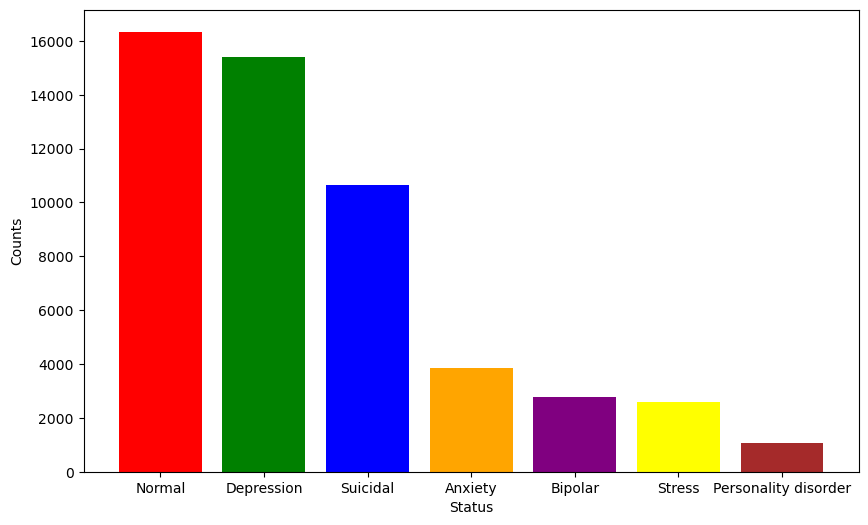

In [185]:
# Visualization of distribution of each Mental Health Status
s_count = df["status"].value_counts()
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown'] 

plt.figure(figsize=(10,6))
plt.bar(s_count.index, s_count.values, color=colors[:len(s_count)])
plt.xlabel("Status")
plt.ylabel("Counts")
plt.show()

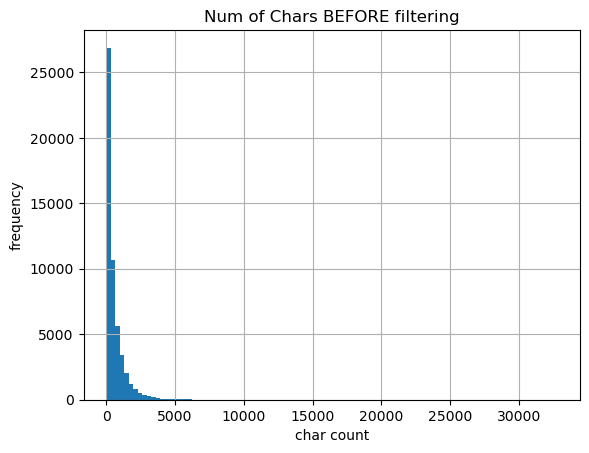

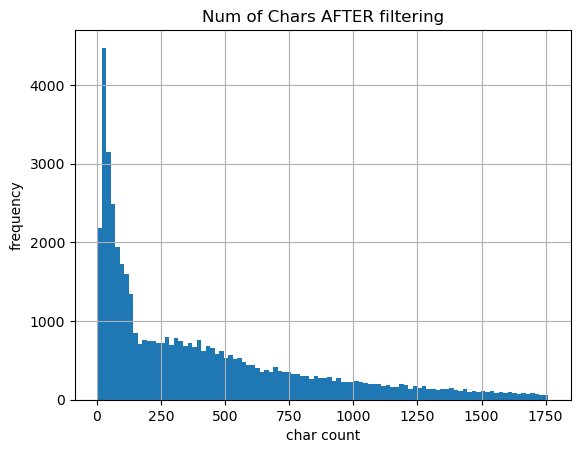

,Unnamed: 0,num_chars
count,52681.000000,52681.000000
mean,26365.706042,578.713863
std,15235.065306,846.269078
min,0.000000,2.000000
25%,13180.000000,80.000000
50%,26350.000000,317.000000
75%,39522.000000,752.000000
max,53042.000000,32759.000000


In [186]:
#remove outliers of the lower quarter percentile and upper quarter percentile of the number of characters

df['num_chars'].hist(bins=100)
plt.title('Num of Chars BEFORE filtering')
plt.xlabel('char count')
plt.ylabel('frequency')
plt.show()



lower_q = df['num_chars'].quantile(.25)
upper_q = df['num_chars'].quantile(.75)
q_range = upper_q - lower_q

lower_bound = lower_q - 1.5 * q_range
upper_bound = upper_q + 1.5 * q_range

filtered_df = df[(df['num_chars'] >= lower_bound) & (df['num_chars'] <= upper_bound) ]
filtered_df['num_chars'].hist(bins=100)
plt.title('Num of Chars AFTER filtering')
plt.xlabel('char count')
plt.ylabel('frequency')
plt.show()
df.describe()


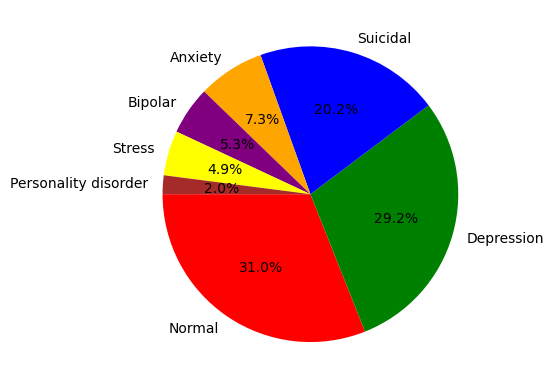

In [187]:
#data is skewed so will need to fix that at some point, shown as pie chart
colors =  ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown'] 
plt.pie(s_count, labels=s_count.index, autopct='%.1f%%', colors=colors, startangle=180)
random_statements = df.groupby("status")["statement"].apply(lambda x: x.sample(n=1)) #this prevents a random print for some reason

   
#status: ('Suicidal', 36299) isnt suicidal, sh
#statement: @realDonaldTrump It already is! At least in France one doesn't die/loss everything when get sick &amp; have at least 1â¦ https://t.co/QYN3ku1Q8T

In [188]:
df['sentence_count'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))
df[['num_chars', 'sentence_count']].describe()

,num_chars,sentence_count
count,52681.000000,52681.000000
mean,578.713863,6.280215
std,846.269078,10.688388
min,2.000000,1.000000
25%,80.000000,1.000000
50%,317.000000,3.000000
75%,752.000000,8.000000
max,32759.000000,1260.000000


In [189]:
#get random values for each of the status types as examples
random_statements = df.groupby("status")["statement"].apply(lambda x: x.sample(n=1))
for status, statement in random_statements.items():
    print(f"status: {status}")
    print(f"statement: {statement}", end="\n\n-----------------------------------------------\n")

status: ('Anxiety', 582)
statement: Between sad, anxious, ah! Gtw deh

-----------------------------------------------
status: ('Bipolar', 46268)
statement: Psychosis or just anxiety? Recently I've been having this strong feeling that people around me can tell what I'm thinking, tell that I'm constantly thinking about killing myself. I feel like people are always looking at me with this mix of pity and disgust because they can tell I'm suicidal. It makes me feel really anxious about being out in public. I *know* it's not possible for people to hear my thoughts, but I can't shake the feeling that they can.

This started happening a couple days ago, after I quit all my meds cold turkey about two weeks ago (I know, not smart).

Could this be psychosis, or am I just anxious?

-----------------------------------------------
status: ('Depression', 38136)
statement: it s so strange waking up everyday with this sense that you want thing to go back to the way they were like your brain ha it own

In [190]:
import re
#convert the statements all to lower case to keep tokenization consistent
df['statement'] = df['statement'].str.lower()
#remove puncuation, markdown, urls, special chars
def remove_special_inputs(text):
    text = re.sub(r"http[s]?://\S+","",text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', "", text)
    # Remove handles (that start with '@')
    text = re.sub(r"@\w+","",text)
    # Remove punctuation and other special characters
    text = re.sub(r"[^\w\s]","",text)
    return text
df['statement'] = df['statement'].apply(remove_special_inputs)
df.head()


,Unnamed: 0,statement,status,num_chars,sentence_count
0,0,oh my gosh,Anxiety,10,1
1,1,trouble sleeping confused mind restless heart ...,Anxiety,64,2
2,2,all wrong back off dear forward doubt stay in ...,Anxiety,78,2
3,3,ive shifted my focus to something else but im ...,Anxiety,61,1
4,4,im restless and restless its been a month now ...,Anxiety,72,2


In [191]:
#need to tokenize each the elements in the statement column of the data
#use the word_tokenize from nltk to divide the string into individual words
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['tokens'] = df['statement'].apply(lambda x: remove_stopwords(x))



In [192]:
""""
#data augmentation to increase data set size, do this by
#translating it to another language and then back
#kind of like how on google translate it may not exactly translate
#Original Text: "The cat is on the mat."
#Translated to French: "Le chat est sur le tapis."
#Back Translated to English: "The cat is on the carpet."
# can add this in later
def augment(text):
    try:
        blob = TextBlob(text)
        translate = blob.translate(to='fr').translate(to='en')
        return str(translate)
    except:
        return text
df['augment_statement'] = df['statement'].apply(augment)
augmented_df = df[['statement', 'status']].copy()
augmented_df['statement'] = df['augment_statement']
df = pd.concat([df, augmented_df])

    """

'"\n#data augmentation to increase data set size, do this by\n#translating it to another language and then back\n#kind of like how on google translate it may not exactly translate\n#Original Text: "The cat is on the mat."\n#Translated to French: "Le chat est sur le tapis."\n#Back Translated to English: "The cat is on the carpet."\n# can add this in later\ndef augment(text):\n    try:\n        blob = TextBlob(text)\n        translate = blob.translate(to=\'fr\').translate(to=\'en\')\n        return str(translate)\n    except:\n        return text\ndf[\'augment_statement\'] = df[\'statement\'].apply(augment)\naugmented_df = df[[\'statement\', \'status\']].copy()\naugmented_df[\'statement\'] = df[\'augment_statement\']\ndf = pd.concat([df, augmented_df])\n\n    '

In [193]:
#need to stem the the tokens to eliminate prefix and suffixes to get the root word
#this will standardize the words used in the training data for the model, 
#this takes about a minute to run fyi
stemmer = PorterStemmer() #initialize stemmer

def token_stemming(tokens):
  return ''.join(stemmer.stem(str(token)) for token in tokens)

df['tokens_stem'] = df['tokens'].apply(token_stemming)

df.sample(5)

,Unnamed: 0,statement,status,num_chars,sentence_count,tokens,tokens_stem
4811,4811,sulli has 2 older brothers,Normal,27,1,sulli 2 older brothers,sulli 2 older brothers
12692,12692,i had my daughter 9 weeks early 8 weeks ago fr...,Suicidal,1500,16,daughter 9 weeks early 8 weeks ago preeclampsi...,daughter 9 weeks early 8 weeks ago preeclampsi...
12510,12510,twive gone on a very bad downward spiral again...,Depression,4405,59,twive gone bad downward spiral recently tried ...,twive gone bad downward spiral recently tried ...
26099,26099,everyone struggles of course it is not like ot...,Depression,363,4,everyone struggles course like people problems...,everyone struggles course like people problems...
47153,47153,31f i hate my life i know it just comes with t...,Depression,2794,19,31f hate life know comes trauma idea compact f...,31f hate life know comes trauma idea compact f...


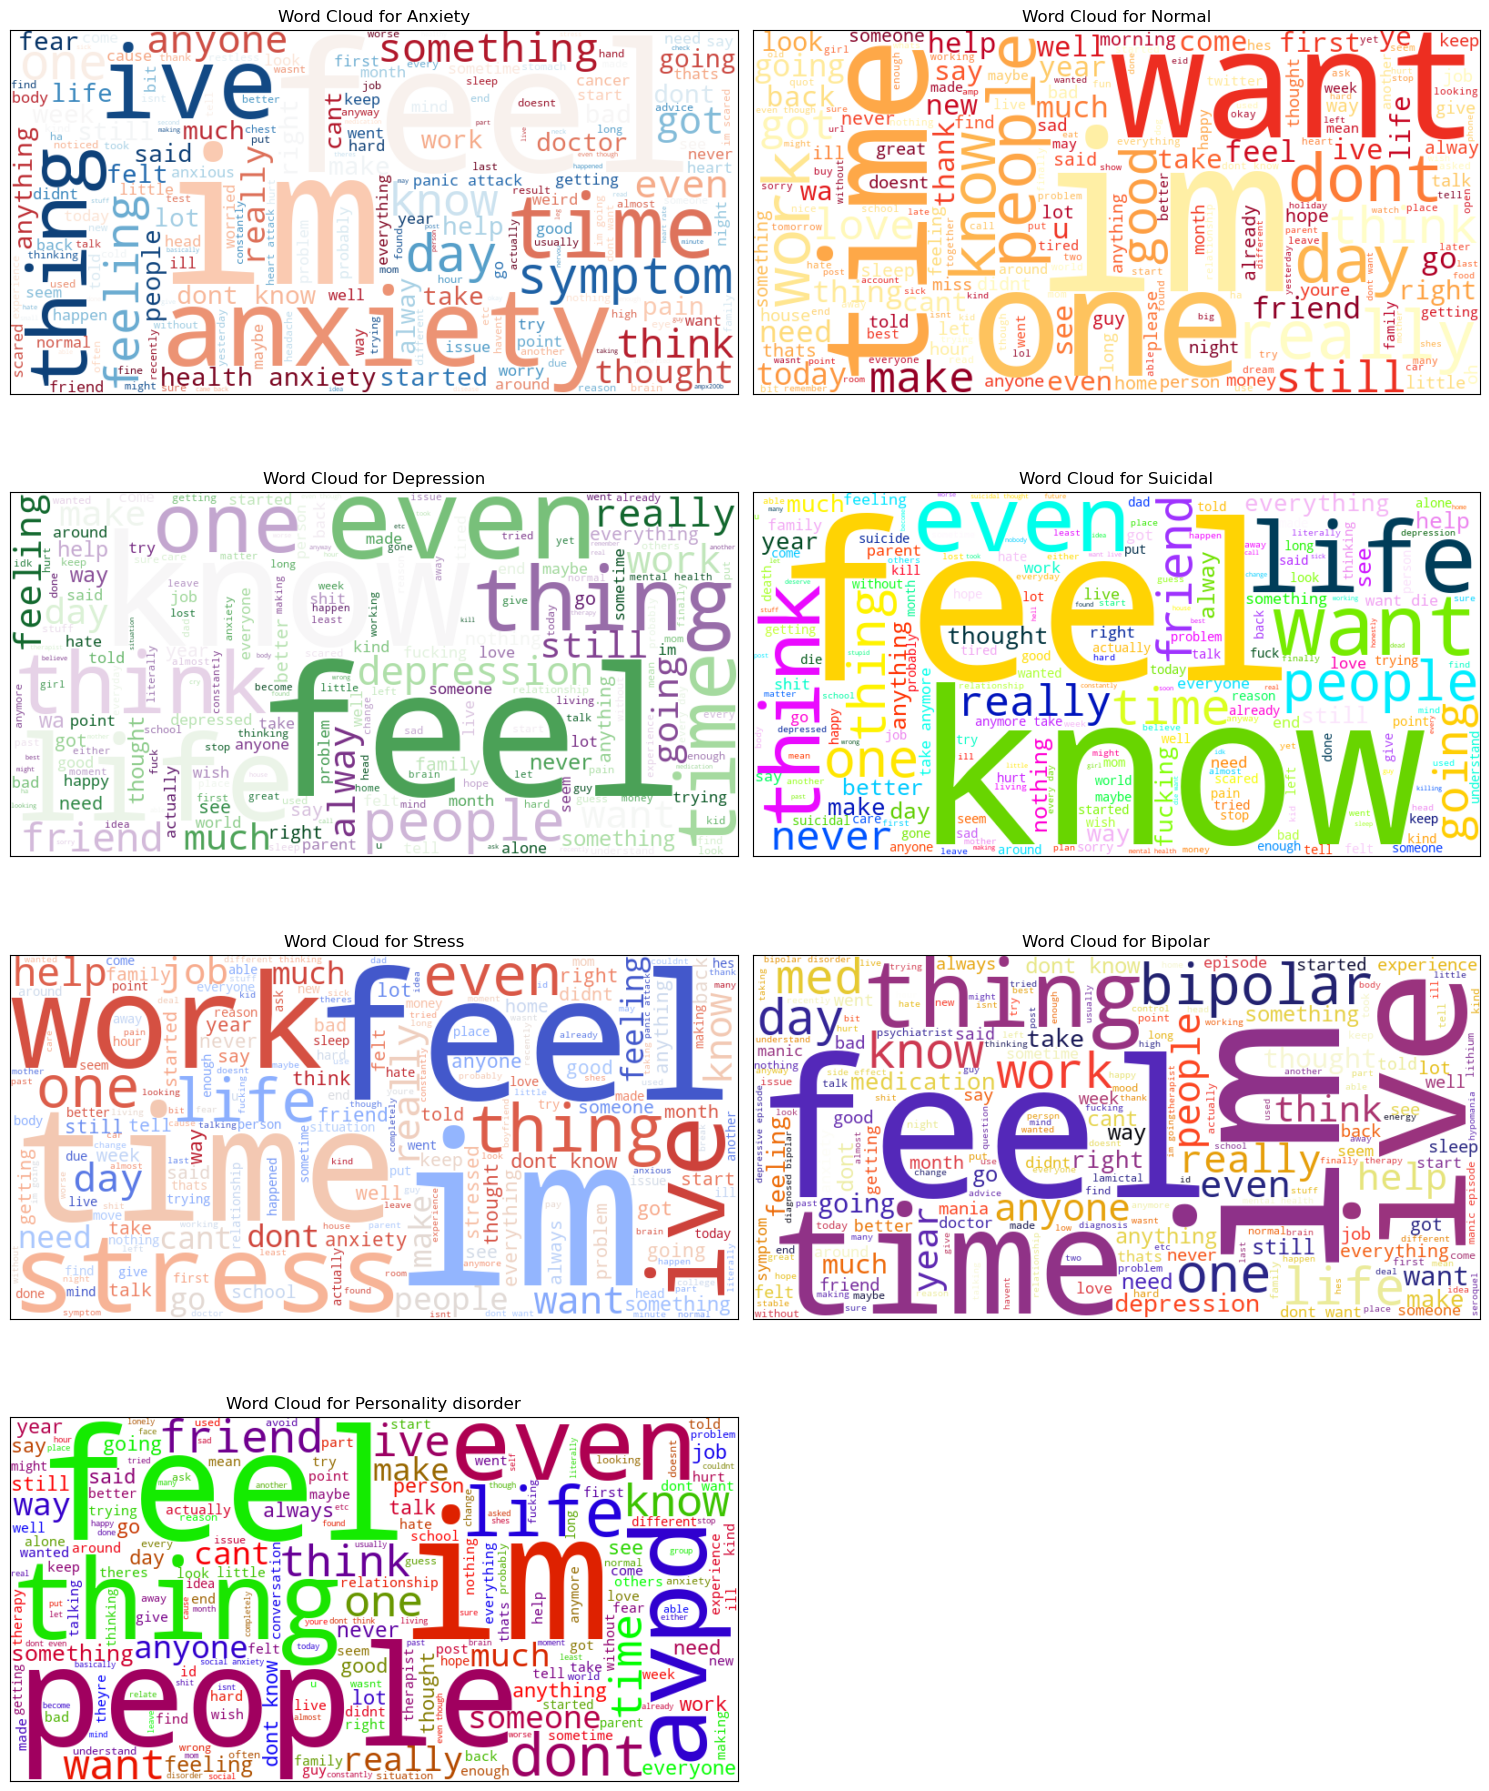

In [194]:
#word collages can help show the common words for each condition
#colormap =  RdBu

unique_status = df['status'].unique()
plt.figure(figsize=(15, 45))
color_map_array = ['RdBu', 'YlOrRd', 'PRGn_r','gist_ncar_r', 'coolwarm', 'CMRmap', 'brg']
for i, status in enumerate(unique_status):
  tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ''.join(x)).tolist())
  word_cloud = WordCloud(width=800, height=400, background_color='white', colormap=color_map_array[i]).generate(tokens_data)
  axes = plt.subplot(len(unique_status) // 2 + 1, 2, i+1)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.title(f'Word Cloud for {status}')
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=-.85)
plt.show()


In [195]:
#set the x values we will be examining, the stemmed tokens, word and, char count
#we compare these against the status as the y values
x = df[['tokens_stem', 'num_chars', 'sentence_count']]
y = df['status']
print(y)


0        Anxiety
1        Anxiety
2        Anxiety
3        Anxiety
4        Anxiety
          ...   
53038    Anxiety
53039    Anxiety
53040    Anxiety
53041    Anxiety
53042    Anxiety
Name: status, Length: 52681, dtype: object


In [196]:
#encode the y values, status, to be represented as numerical values. turn anxiety to 0
#IF YOU GET AN ERROR RUNNING THIS, RUN THE CELL ABOVE AND TRY AGAIN, IF THIS FAILS IT OVERWRITES Y AND 
#PULLS A JUPYTER NOTEBOOK MOMENT WHERE Y SHOULDNT BE MODIFIED BUT AGAIN JUPYTER NOTEBOOKS 🤬
#encoder = LabelEncoder()
#y = encoder.fit_transform(y.values)
#print(y)


In [197]:
#we use train_test_split function on data
#idk when you are supposed to use a new cell in jupyter notebook typically
#im just doing it after doing an operation or function on some data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

In [198]:
#now we will convert the text to features 
#we do this via tfidf or Term Frequency-Inverse Document Frequency
#we determine how important a given word is to a status by determining the frequency of a word in the TOTAL dataset
#if word t in data set d the term frequency is equal to (num of t) / (num of words in d)
vector = TfidfVectorizer(max_features=10000)
x_train_tfid = vector.fit_transform(x_train['tokens_stem'])
x_test_tfid = vector.transform(x_test['tokens_stem'])

#now need the numerical features of the training and testing data
x_train_num = x_train[['num_chars', 'sentence_count']].values
x_test_num = x_test[['num_chars', 'sentence_count']].values

#lastly combine the tfid with the numerical values
combined_x_train = hstack([x_train_tfid, x_train_num])
combined_x_test = hstack([x_test_tfid, x_test_num])

print('feature word count: ', len(vector.get_feature_names_out())) #should be 50000
combined_x_train.shape #should be 42144, 50002

feature word count:  10000


(42144, 10002)

In [199]:
#this takes about 4.5 minutes to run with max_features = 50000, change the max_features to 10k (in above cell) for it to be about 1.5 minutes
param_grid = {
    'C' : [.01, .1, 1, 10, 100]
}
model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_tfid, y_train)
best_model = grid_search.best_estimator_


In [200]:
y_pred = best_model.predict(x_test_tfid)

In [201]:
print('Best param_grid value(s): ', grid_search.best_params_)
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Classification_report:')
print(classification_report(y_test, y_pred))


Best param_grid value(s):  {'C': 1}
Accuracy score:  0.7633102401062921
Classification_report:
                      precision    recall  f1-score   support

             Anxiety       0.83      0.76      0.80       755
             Bipolar       0.85      0.73      0.79       527
          Depression       0.70      0.73      0.71      3016
              Normal       0.84      0.95      0.89      3308
Personality disorder       0.85      0.48      0.61       237
              Stress       0.74      0.47      0.58       536
            Suicidal       0.68      0.64      0.66      2158

            accuracy                           0.76     10537
           macro avg       0.78      0.68      0.72     10537
        weighted avg       0.76      0.76      0.76     10537



In [205]:
cm = confusion_matrix(y_test, y_pred)
fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(set(y_test)),
    y=list(set(y_test)),
    annotation_text=cm,
    colorscale='Viridis'
)
fig.update_layout(title='Confusion Matrix')
fig.show()


In [202]:
#was using this for xgb but not needed anymore without xgb
#now need random sampling
#r = RandomOverSampler(random_state=42)
#x_train_r, y_train_r = r.fit_resample(combined_x_train, y_train)
#x_train_r.shape

In [203]:
#i gave up on this bc after 30 minutes it still hadnt finished
#this is a gradient booster algorithm.
#idk what it actually does bc ML seems to just be importing modules to
#the machine learning part
#xgb_clf = XGBClassifier(learing_rate=.5, max_depth =7, n_estimators=500, random_state=42, tree_method ="hist")
#xgb_clf.fit(x_train_r, y_train_r)
#y_pred = xgb_clf.predict(combined_x_test)

#xgb_clf = XGBClassifier(learning_rate=0.5, max_depth=7, n_estimators=500, random_state=101, n_jobs=-1)
# Train the classifier on the resampled training data
#xgb_clf.fit(x_train_r, y_train_r)
# Predict the labels on the test data
#y_pred = xgb_clf.predict(combined_x_test)